In [6]:
# Import functions
import numpy as np
import matplotlib.pyplot as p
% matplotlib inline

import eigencurves
import kmeans
#import mapPCA
import bin_eigenspectra

from importlib import import_module
planet_name = 'HD189733b'
system = import_module('data.planet.{}'.format(planet_name))

### Import spectra and generate map

In [ ]:
# ...

### Generate lightcurve using STARRY

In [ ]:
# ...

### Fit eigencurves to lightcurve

In [14]:
lcfile = 'data/output_lightcurves/practice1p01renorm'
spherearray = eigencurves.eigencurves(lcfile)
# spherearray is an array of wavelength x SH coefficents

/home/jacob/mdworlds/eigencurves.py:148: ComplexWarning: Casting complex values to real discards the imaginary part
  spheres[i] += fcoeff.T[j,2*i-1]-fcoeff.T[j,2*(i-1)]


Do we need to output the full posteriors?

In [18]:
print(spherearray.shape)

(10, 10)


### Turn SH coefficients into maps

(example)

In [ ]:
# ...

# Loop over 5. to get errors

In [20]:
ngroups = 2
samples = [spherearray] # output from eigencurves

eigenspectra_draws = []
kgroup_draws = []
for draw in samples:
    
    maps = turn_coefs_into_maps(draw)
    
    kgroups = kmeans.kmeans(maps, ngroups)
    
    eigenspectra = bin_eigenspectra.bin_eigenspectra(maps, kgroups)
    
    eigenspectra_draws.append(eigenspectra)
    kgroup_draws.append(kgroups)

NameError: name 'turn_coefs_into_maps' is not defined

In [ ]:
eigenspectra = np.mean(eigenspectra_draws, axis=0)
eigenerrs = np.std(eigenspectra_draws, axis=0)

kgroups = np.mean(kgroups_draws, axis=0)

In [21]:
for spec, err in zip(eigenspectra, eigenerrs):
    p.errorbar(waves, spec, err)
p.xlabel('Wavelength (micron)')
p.ylabel('Fp/Fs (ppm)')
p.title('Eigenspectra from light-curve fit')
p.show()

NameError: name 'eigenspectra' is not defined

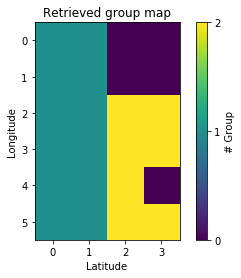

In [39]:
ax = p.imshow(kgroups)
cbar = p.colorbar(ax, ticks=np.arange(ngroups))
cbar.set_label('# Group')
p.xlabel('Latitude')
p.ylabel('Longitude')
p.title('Retrieved group map')
p.show()

# Tests

### Creat a fake data set

Fake data 1, two distinct spectra

(10, 6, 4)


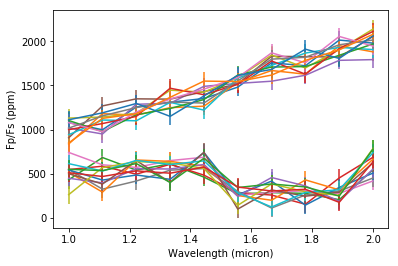

In [23]:
lamdim = 10
latdim = 6
londim = 4
ngroups = 3

# dummy flux values
waves = np.linspace(1,2,lamdim) # micron
spec1 = np.linspace(1000,2000,lamdim) # in ppm
spec2 = np.linspace(500,600,lamdim) # in ppm
spec2[lamdim//2:-1] *= 0.5

spectra1 = [[ spec1+np.random.normal(0,100,lamdim) for _ in range(latdim) ] for __ in range(londim//2)]
spectra2 = [[ spec2+np.random.normal(0,100,lamdim) for _ in range(latdim) ] for __ in range(londim//2)]
fp_grid = np.array(spectra1+spectra2).T
print(fp_grid.shape) # should be wave, lat, lon


for lat in range(latdim):
    for lon in range(londim):
        spec = fp_grid[:,lat,lon]
        err = 100 # ppm
        p.errorbar(waves, spec, err)
p.ylabel('Fp/Fs (ppm)')
p.xlabel('Wavelength (micron)')
p.show()

Fake data 2, smoothly varying spectra

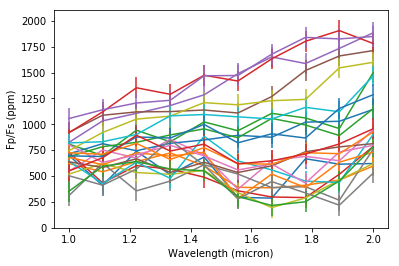

In [24]:
fp_grid2 = np.empty((lamdim,latdim,londim))
for lat in range(latdim):
    for lon in range(londim):
        f = np.random.uniform(0,1)**2
        err = np.random.normal(0,100,lamdim)
        fp_grid2[:, lat, lon] = f*spec1 + (1-f)*spec2 + err


for lat in range(latdim):
    for lon in range(londim):
        spec = fp_grid2[:,lat,lon]
        err = 100 # ppm
        p.errorbar(waves, spec, err)
p.ylabel('Fp/Fs (ppm)')
p.xlabel('Wavelength (micron)')
p.show()

### Get groups from K-means clustering

In [25]:
kgroups = kmeans.kmeans(fp_grid, ngroups)

kgroups2 = kmeans.kmeans(fp_grid2, ngroups)

### Create eigenspectra from K-mean clustering output

In [26]:
eigenspectra = bin_eigenspectra.bin_eigenspectra(fp_grid, kgroups)

eigenspectra2 = bin_eigenspectra.bin_eigenspectra(fp_grid2, kgroups2)

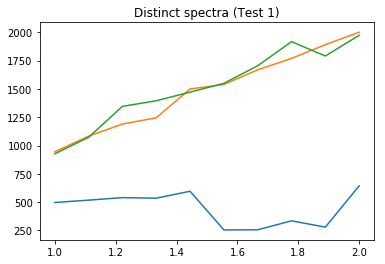

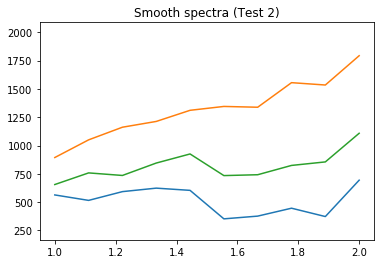

In [27]:
for spec in eigenspectra:
    p.plot(waves, spec)
p.title('Distinct spectra (Test 1)')
ylim = p.ylim()
p.show()

for spec in eigenspectra2:
    p.plot(waves, spec)
p.title('Smooth spectra (Test 2)')
p.ylim(ylim)
p.show()